# Классификация Oxford Pets

Импортируем необходимые библиотеки

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn

import seaborn as sns
import pandas as pd

from sklearn.metrics import confusion_matrix

Установим сид в функции `random` и сконфигурируем устройство (`cpu` либо `gpu`)

In [20]:
SEED = 2904
np.random.seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)
DEVICE = 'cpu'
img_size = 256, 256
batch_size = 64

## Обработка входных данных

### Загрузка датасета

[Датасет](https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset) загрузил вручную и распаковали архив в папку dataset

In [21]:
images = os.listdir('dataset/images/')

Теперь определим классы датасета

In [22]:
def get_class(string):
    for i, ch in enumerate(string):
        if ch.isdigit():
            return string[:i-1]
        
classes = list(set([get_class(img) for img in images if get_class(img) is not None]))

### Разделение на обучающую и тестовую выборки

In [24]:
os.makedirs('dataset/train/')
os.makedirs('dataset/val/')
val_size = 0.2

for cl in classes:
    os.makedirs(os.path.join('dataset/train/', cl))
    os.makedirs(os.path.join('dataset/val/', cl))

for i, image in enumerate(images):
    cur_class = get_class(image)
    if cur_class is None:
        continue
    if np.random.random(1) < 1 - val_size:
        shutil.copy(os.path.join('dataset/images', image), os.path.join('dataset/train', cur_class))
    else:
        shutil.copy(os.path.join('dataset/images', image), os.path.join('dataset/val', cur_class))

In [25]:
transform = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

train = datasets.ImageFolder('dataset/train', transform=transform)
val = datasets.ImageFolder('dataset/val', transform=transform)

Сделаем даталоадеры

In [26]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)

## Обучение моделей

In [36]:
def train_model(model, train_loader, test_loader, epochs_num, optimizer, criterion, device):
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []
    train_top3_acc_history = []  
    test_top3_acc_history = []
    train_top5_acc_history = [] 
    test_top5_acc_history = []

    for _ in range(epochs_num):
        cur_train_acc = 0
        cur_test_acc = 0
        cur_train_loss = 0
        cur_test_loss = 0
        cur_train_top3_acc = 0  
        cur_test_top3_acc = 0
        cur_train_top5_acc = 0  
        cur_test_top5_acc = 0

        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            cur_train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cur_train_acc += (y_batch == torch.argmax(y_pred, axis=1)).sum().item()

            _, top3_pred = torch.topk(y_pred, k=3, dim=1) 
            cur_train_top3_acc += (y_batch.unsqueeze(1) == top3_pred).any(dim=1).sum().item()

            _, top5_pred = torch.topk(y_pred, k=5, dim=1)
            cur_train_top5_acc += (y_batch.unsqueeze(1) == top5_pred).any(dim=1).sum().item()

        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = model(X_batch)
                cur_test_acc += (y_batch == torch.argmax(y_pred, axis=1)).sum().item()
                loss = criterion(y_pred, y_batch)
                cur_test_loss += loss.item()

                # Top-3 accuracy для теста
                _, top3_pred = torch.topk(y_pred, k=3, dim=1)
                cur_test_top3_acc += (y_batch.unsqueeze(1) == top3_pred).any(dim=1).sum().item()

                # Top-5 accuracy для теста
                _, top5_pred = torch.topk(y_pred, k=5, dim=1)
                cur_test_top5_acc += (y_batch.unsqueeze(1) == top5_pred).any(dim=1).sum().item()

        total_train = len(train_loader.dataset)
        total_test = len(test_loader.dataset)

        train_acc_history.append(cur_train_acc / total_train)
        test_acc_history.append(cur_test_acc / total_test)
        train_top3_acc_history.append(cur_train_top3_acc / total_train)  # Top-3 train
        test_top3_acc_history.append(cur_test_top3_acc / total_test)     # Top-3 test
        train_top5_acc_history.append(cur_train_top5_acc / total_train)  # Top-5 train
        test_top5_acc_history.append(cur_test_top5_acc / total_test)     # Top-5 test

        train_loss_history.append(cur_train_loss / len(train_loader))
        test_loss_history.append(cur_test_loss / len(test_loader))
        
    return (train_loss_history, 
            test_loss_history, 
            train_acc_history, 
            test_acc_history,
            train_top3_acc_history,
            test_top3_acc_history,
            train_top5_acc_history,
            test_top5_acc_history)

In [37]:
def plot_loss(train_loss, test_loss):
    plt.figure(figsize=(10, 10))
    plt.title("Loss")
    plt.plot(range(1, len(train_loss) + 1), train_loss, linewidth=2, label='train loss')
    plt.plot(range(1, len(test_loss) + 1), test_loss, linewidth=2, label='test loss')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [47]:
def plot_acc(train_acc, test_acc):
    plt.figure(figsize=(10, 10))
    plt.title("Accuracy")
    plt.plot(range(1, len(train_acc) + 1), train_acc, linewidth=2, label='train accuracy')
    plt.plot(range(1, len(test_acc) + 1), test_acc, linewidth=2, label='test accuracy')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

## Модель VGG16

In [74]:
vgg = models.vgg16(pretrained=True)

C:\Users\BaronPipistron\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
vgg.classifier[-1] = nn.Linear(4096, len(classes))

vgg = vgg.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=1e-4)

epochs = 5

In [44]:
train_loss, test_loss, train_acc, test_acc, train_top3, test_top3, train_top5, test_top5 = train_model(
    vgg, 
    train_loader, 
    val_loader, 
    epochs, 
    optimizer, 
    criterion, 
    DEVICE
)                                 

#### VGG16 Accuracy

In [51]:
print("Top-1 Train Accuracy:", train_acc[-1])
print("Top-1 Test Accuracy:", test_acc[-1])

print("Top-3 Train Accuracy:", train_top3[-1])
print("Top-3 Test Accuracy:", test_top3[-1])

print("Top-5 Train Accuracy:", train_top5[-1])
print("Top-5 Test Accuracy:", test_top5[-1])

Top-1 Train Accuracy: 0.9629319020462932
Top-1 Test Accuracy: 0.8907563025210085
Top-3 Train Accuracy: 0.9974840657497485
Top-3 Test Accuracy: 0.9859943977591037
Top-5 Train Accuracy: 0.9998322710499832
Top-5 Test Accuracy: 0.992296918767507


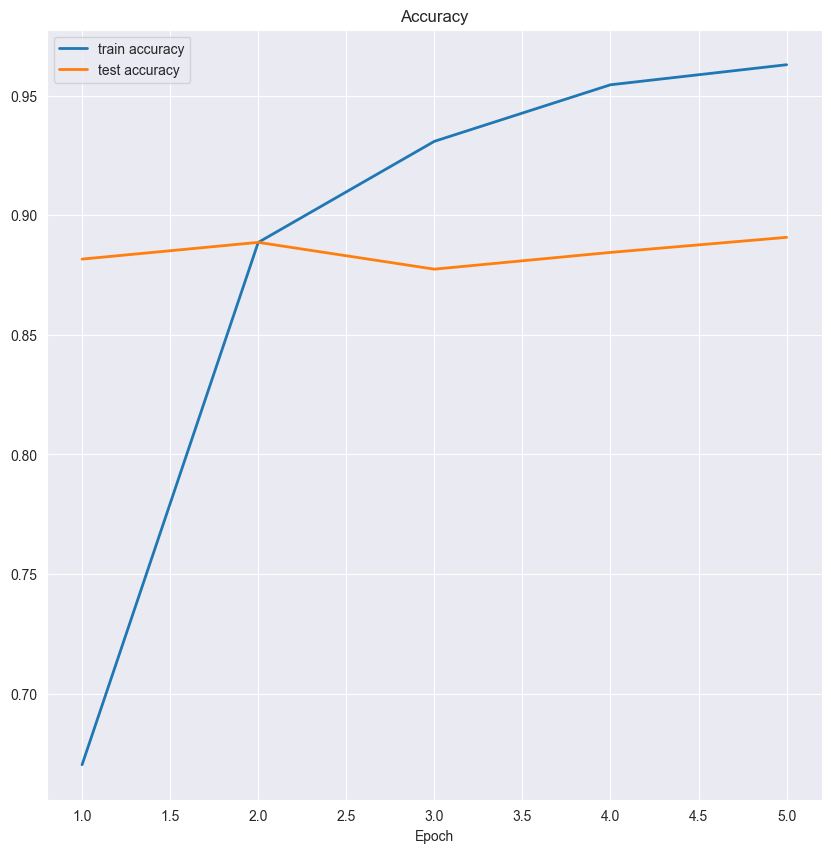

In [48]:
plot_acc(train_acc, test_acc)

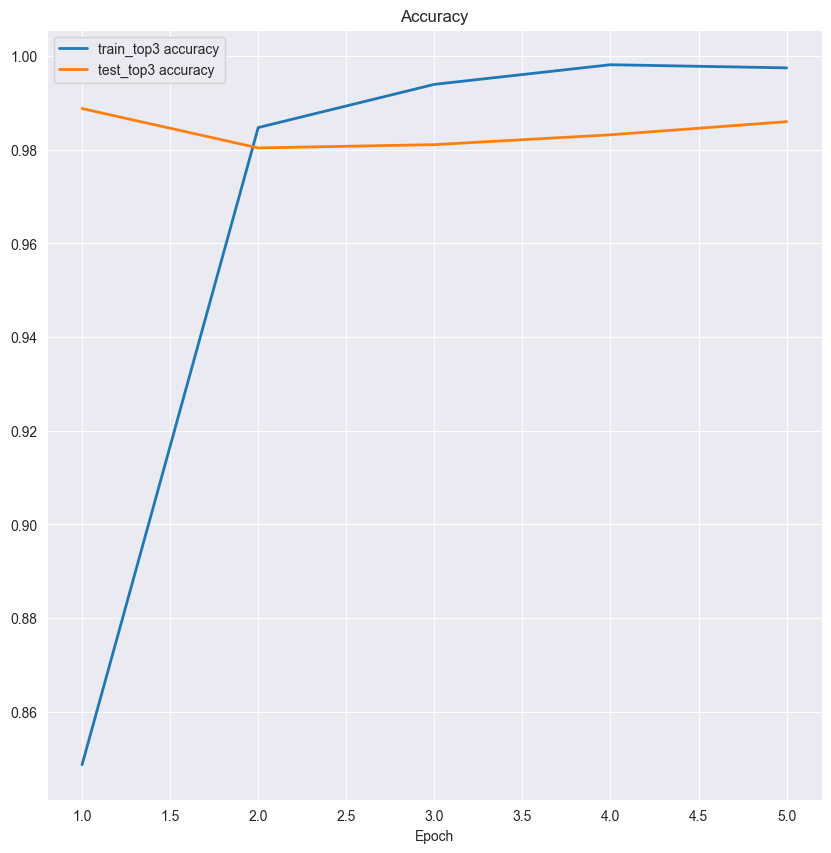

In [49]:
plt.figure(figsize=(10, 10))
plt.title("Accuracy")
plt.plot(range(1, len(train_top3) + 1), train_top3, linewidth=2, label='train_top3 accuracy')
plt.plot(range(1, len(test_top3) + 1), test_top3, linewidth=2, label='test_top3 accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

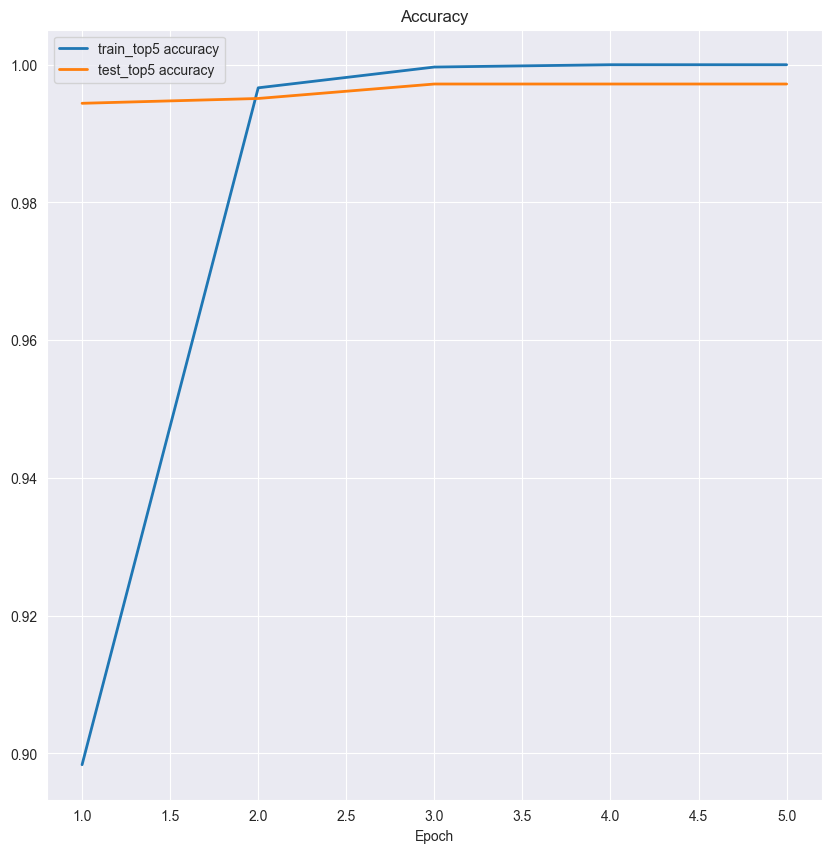

In [59]:
plt.figure(figsize=(10, 10))
plt.title("Accuracy")
plt.plot(range(1, len(train_top5) + 1), train_top5, linewidth=2, label='train_top5 accuracy')
plt.plot(range(1, len(test_top5) + 1), test_top5, linewidth=2, label='test_top5 accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

#### VGG16 Loss

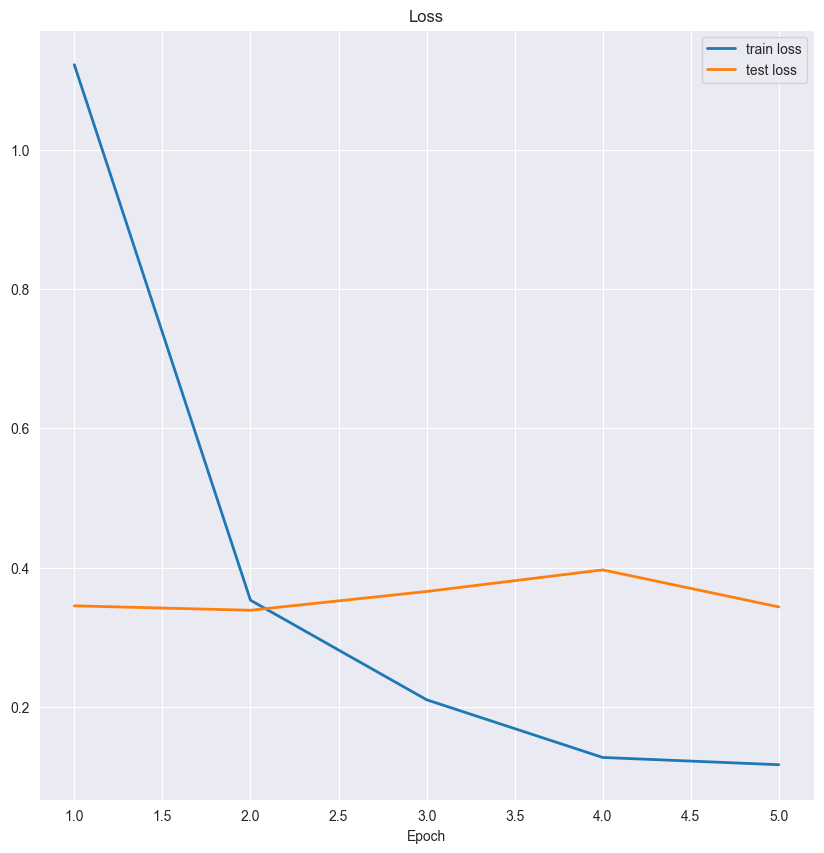

In [52]:
plot_loss(train_loss, test_loss)

**Точность VGG16**

In [53]:
train_acc[-1]

0.9629319020462932

## Модель VGG19

In [65]:
vgg = models.vgg19(pretrained=True)

C:\Users\BaronPipistron\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\BaronPipistron\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\BaronPipistron/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [02:32<00:00, 3.77MB/s] 


In [66]:
vgg.classifier[-1] = nn.Linear(4096, len(classes))

vgg = vgg.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=1e-4)

epochs = 5

In [67]:
train_loss, test_loss, train_acc, test_acc, train_top3, test_top3, train_top5, test_top5 = train_model(
    vgg, 
    train_loader, 
    val_loader, 
    epochs, 
    optimizer, 
    criterion, 
    DEVICE
)   

### VGG19 Accuracy

In [68]:
print("Top-1 Train Accuracy:", train_acc[-1])
print("Top-1 Test Accuracy:", test_acc[-1])

print("Top-3 Train Accuracy:", train_top3[-1])
print("Top-3 Test Accuracy:", test_top3[-1])

print("Top-5 Train Accuracy:", train_top5[-1])
print("Top-5 Test Accuracy:", test_top5[-1])

Top-1 Train Accuracy: 0.9562227440456222
Top-1 Test Accuracy: 0.876750700280112
Top-3 Train Accuracy: 0.9976517946997652
Top-3 Test Accuracy: 0.9789915966386554
Top-5 Train Accuracy: 0.9994968131499496
Top-5 Test Accuracy: 0.9908963585434174


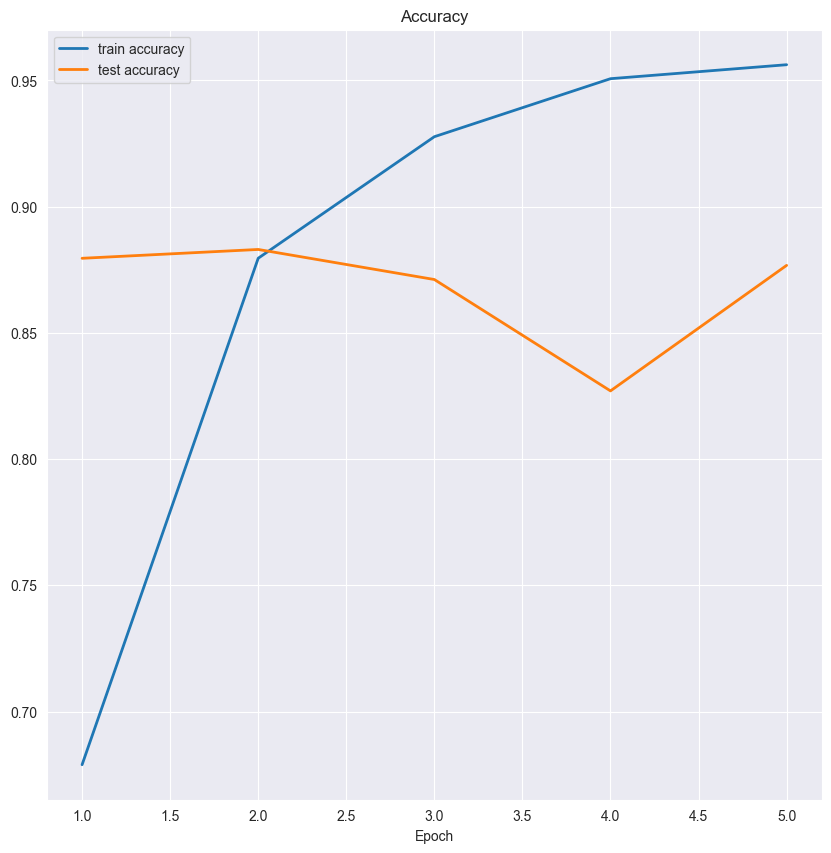

In [69]:
plot_acc(train_acc, test_acc)

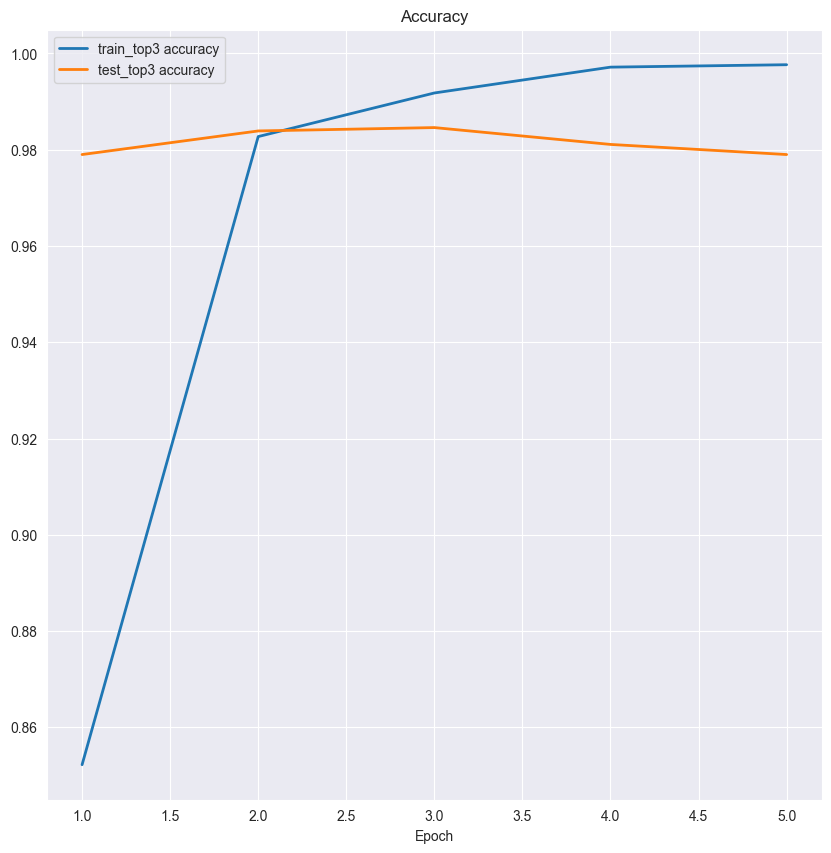

In [70]:
plt.figure(figsize=(10, 10))
plt.title("Accuracy")
plt.plot(range(1, len(train_top3) + 1), train_top3, linewidth=2, label='train_top3 accuracy')
plt.plot(range(1, len(test_top3) + 1), test_top3, linewidth=2, label='test_top3 accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

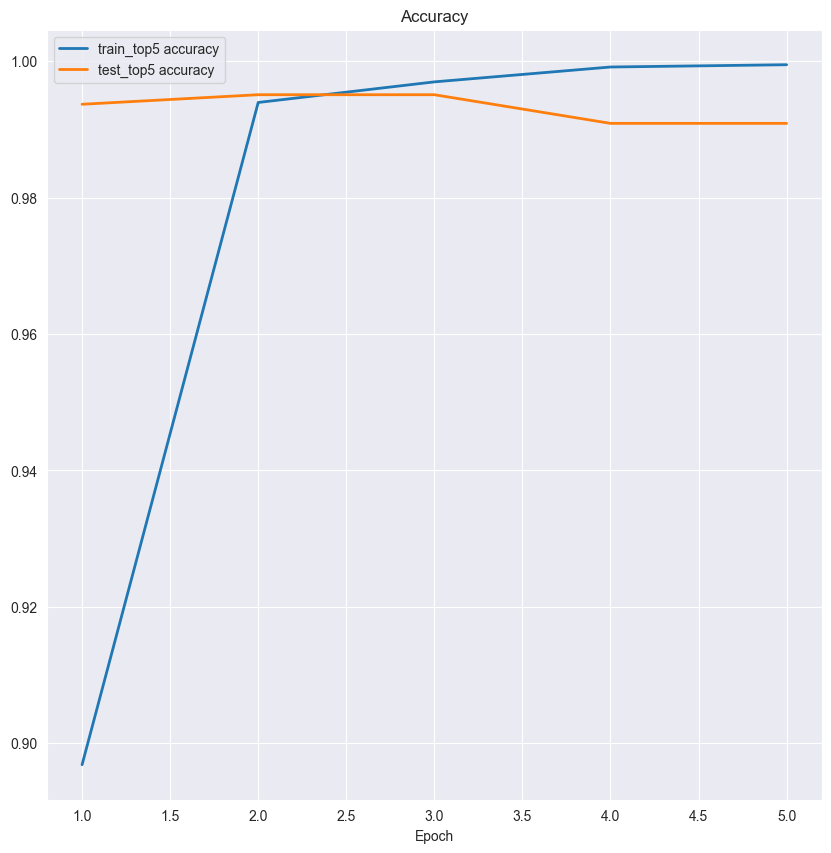

In [71]:
plt.figure(figsize=(10, 10))
plt.title("Accuracy")
plt.plot(range(1, len(train_top5) + 1), train_top5, linewidth=2, label='train_top5 accuracy')
plt.plot(range(1, len(test_top5) + 1), test_top5, linewidth=2, label='test_top5 accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Точность VGG19

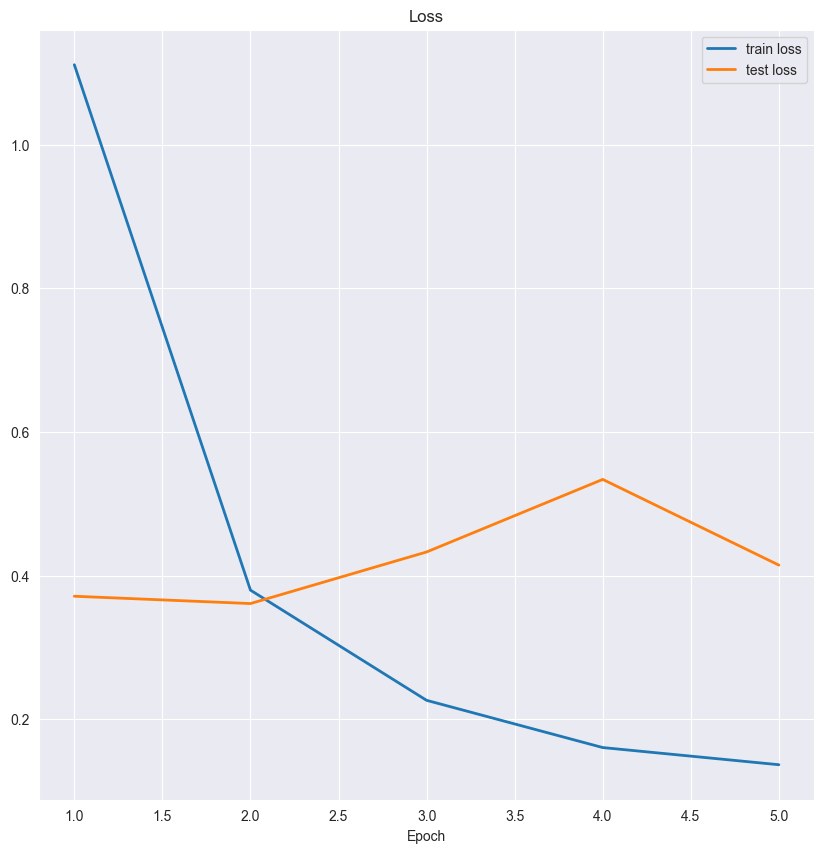

In [72]:
plot_loss(train_loss, test_loss)

In [73]:
train_acc[-1]

0.9562227440456222

## Модель ResNet18

In [54]:
resnet = models.resnet18(pretrained=True)

C:\Users\BaronPipistron\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\BaronPipistron/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:07<00:00, 6.37MB/s]


In [76]:
resnet.fc = nn.Linear(512, len(classes))

resnet = resnet.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

epochs = 5

In [82]:
train_loss, test_loss, train_acc, test_acc, train_top3, test_top3, train_top5, test_top5 = train_model(
    resnet, 
    train_loader, 
    val_loader, 
    epochs, 
    optimizer, 
    criterion, 
    DEVICE
)

#### ResNet Accuracy

In [83]:
print("Top-1 Train Accuracy:", train_acc[-1])
print("Top-1 Test Accuracy:", test_acc[-1])

print("Top-3 Train Accuracy:", train_top3[-1])
print("Top-3 Test Accuracy:", test_top3[-1])

print("Top-5 Train Accuracy:", train_top5[-1])
print("Top-5 Test Accuracy:", test_top5[-1])

Top-1 Train Accuracy: 1.0
Top-1 Test Accuracy: 0.9103641456582633
Top-3 Train Accuracy: 1.0
Top-3 Test Accuracy: 0.9789915966386554
Top-5 Train Accuracy: 1.0
Top-5 Test Accuracy: 0.9915966386554622


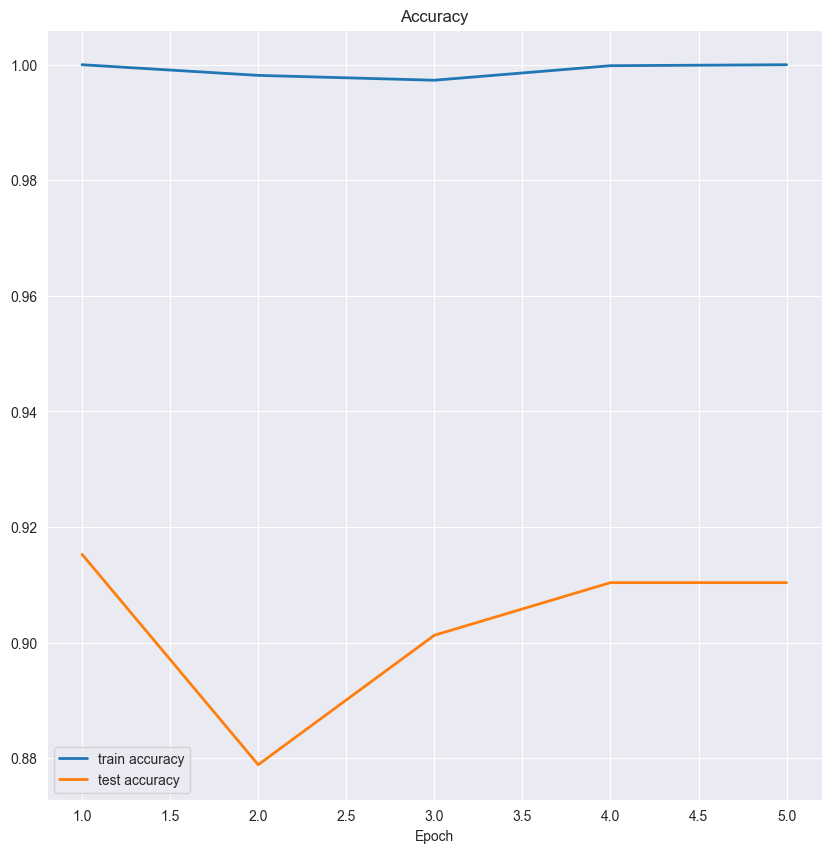

In [87]:
plot_acc(train_acc, test_acc)

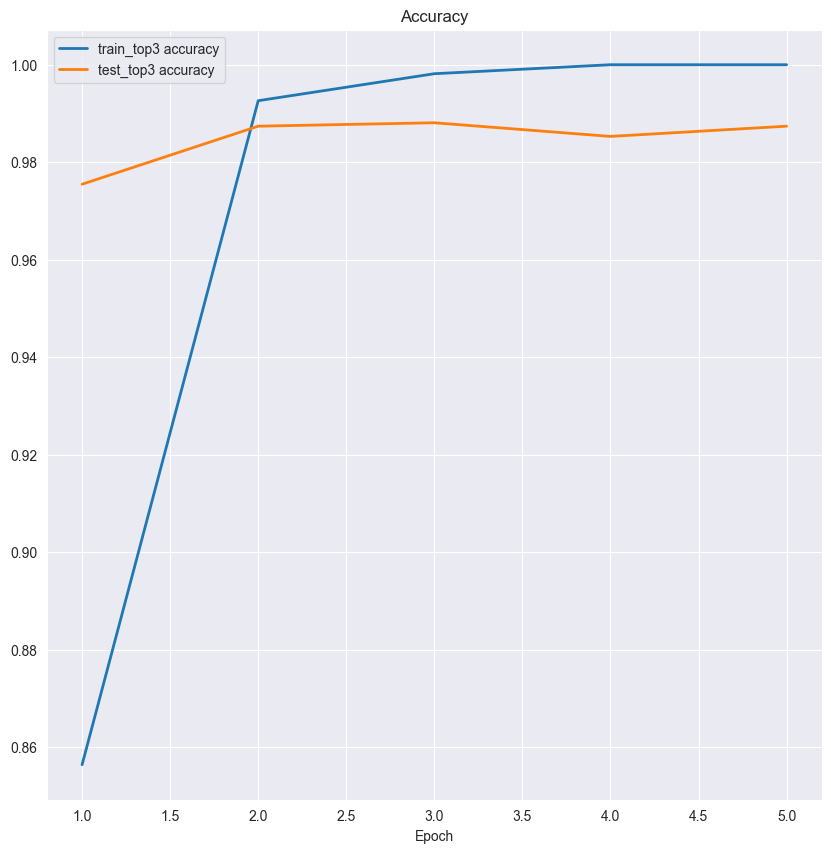

In [58]:
plt.figure(figsize=(10, 10))
plt.title("Accuracy")
plt.plot(range(1, len(train_top3) + 1), train_top3, linewidth=2, label='train_top3 accuracy')
plt.plot(range(1, len(test_top3) + 1), test_top3, linewidth=2, label='test_top3 accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

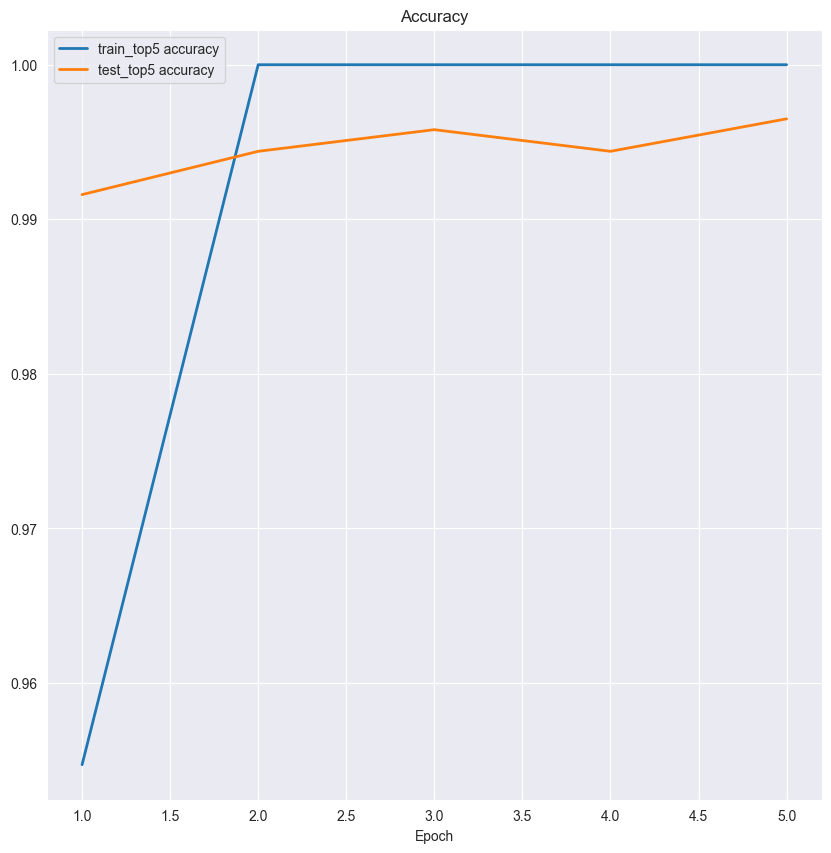

In [80]:
plt.figure(figsize=(10, 10))
plt.title("Accuracy")
plt.plot(range(1, len(train_top5) + 1), train_top5, linewidth=2, label='train_top5 accuracy')
plt.plot(range(1, len(test_top5) + 1), test_top5, linewidth=2, label='test_top5 accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

#### ResNet Loss

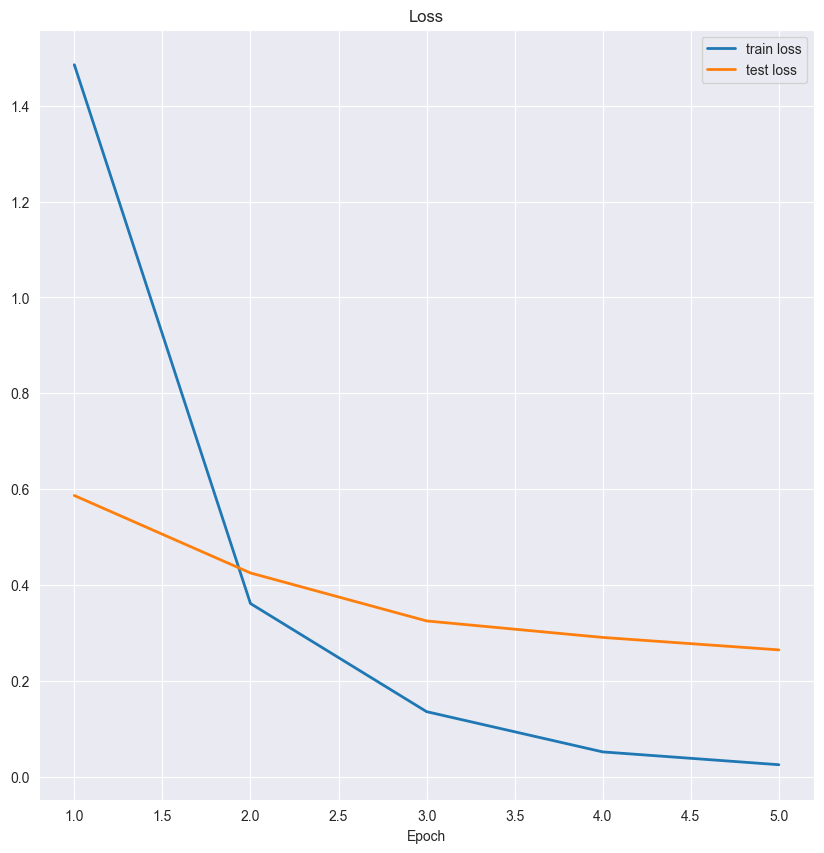

In [61]:
plot_loss(train_loss, test_loss)

**Точность ResNet**

In [62]:
train_acc[-1]

1.0

### Confusion Matrix для ResNet

In [63]:
def plot_confusion_matrix(model, test_loader):
    preds = None
    reals = None
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            y_pred = model(X_batch)
            if preds is None:
                preds = torch.argmax(y_pred, axis=1).cpu().numpy()
                reals = y_batch.cpu().numpy()
            else:
                preds = np.hstack([preds, torch.argmax(y_pred, axis=1).cpu().numpy()])
                reals = np.hstack([reals, y_batch.cpu().numpy()])
    cm = confusion_matrix(reals, preds)
    df_cm = pd.DataFrame(cm, index = [i for i in classes], columns = [i for i in classes])
    plt.figure(figsize = (15, 15))
    sns.heatmap(df_cm, annot=True)
    plt.show()

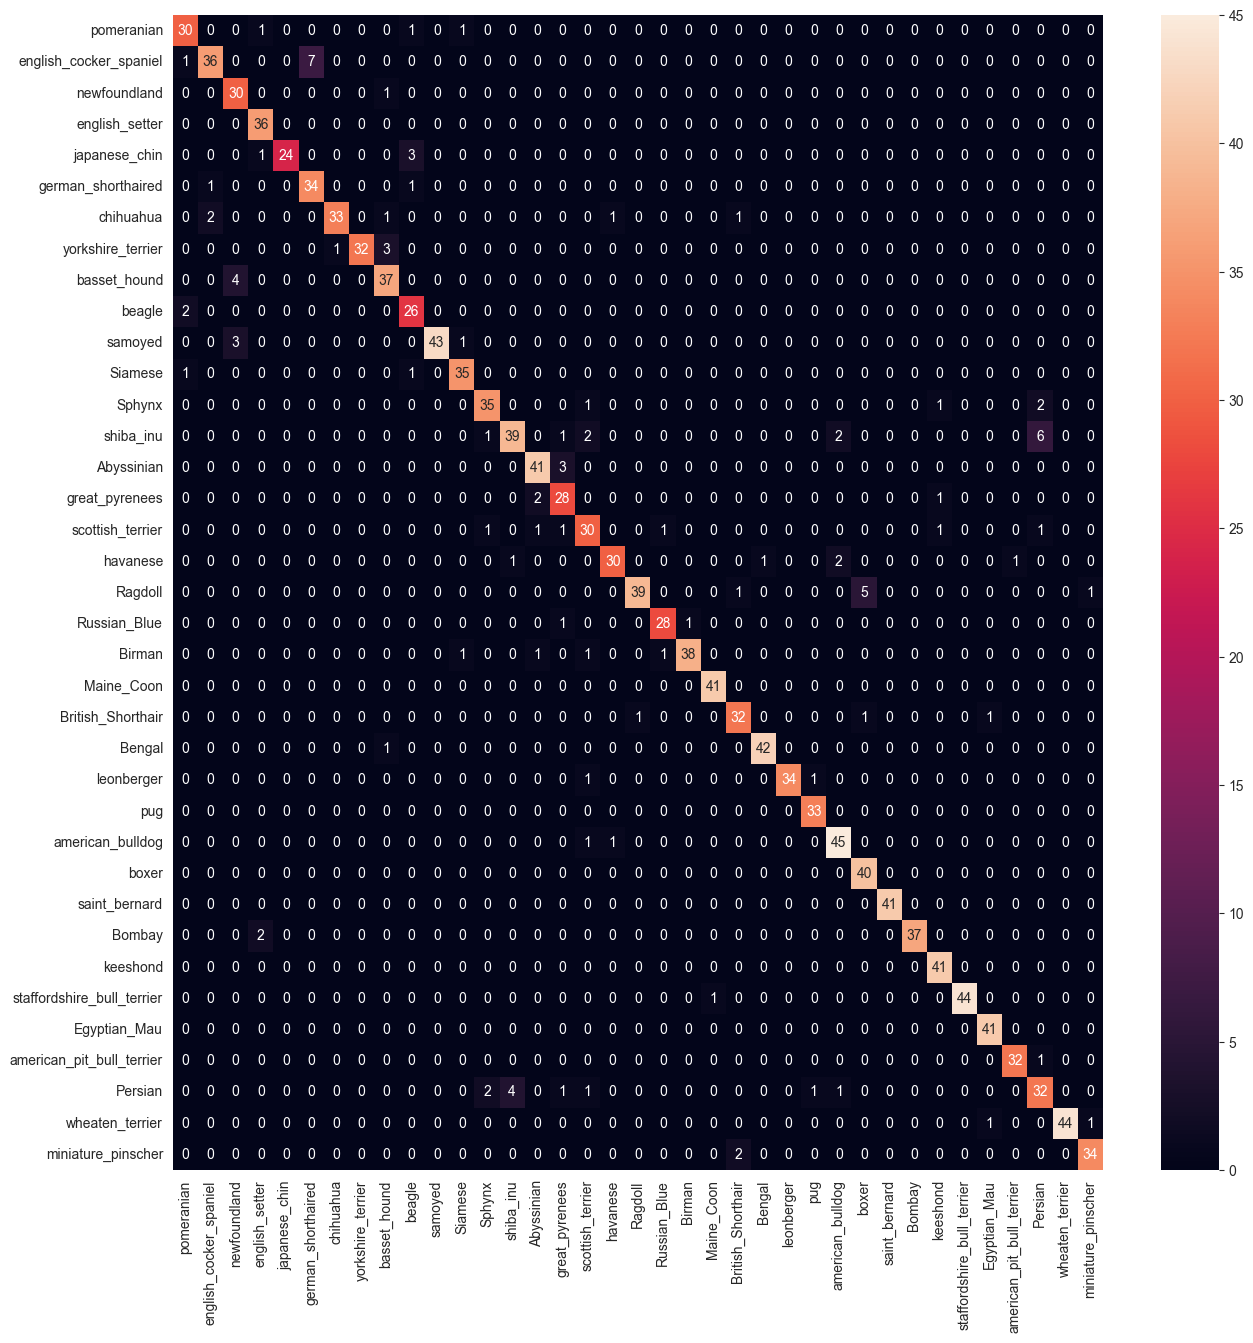

In [64]:
plot_confusion_matrix(resnet, val_loader)